<center> <h2> TP4  : Support Vector Machine (SVM) </h2> </center>

Les SVM ont été introduites par Vapnik [3], et sont abordées au chapitre 12 du livre [1]. Des détails plus
mathématiques peuvent être trouvés dans le chapitre 7 du livre [2]. La popularité des méthodes SVM, pour
la classification binaire en particulier, provient du fait qu’elles reposent sur l’application d’algorithmes
de recherche de règles de décision linéaires : on parle d’hyperplans (affine) séparateurs. Toutefois, cette
recherche s’effectue dans un espace de caractères (
feature space
, en anglais) de très grande dimension qui
est l’image de l’espace d’entrée original par une transformation
Φ
non linéaire.
Le but de ce TP est de mettre en pratique ce type de techniques de classification sur données réelles et
simulées au moyen du package
scikit-learn
(lequel met en œuvre la librairie en
C
libsvm
) et d’apprendre
à contrôler les paramètres garantissant leur flexibilité (hyper-paramètres, noyau).

[1] T. Hastie, R. Tibshirani, and J. Friedman.
The elements of statistical learning
.  Springer Series
in Statistics. Springer, New York, second edition, 2009.
http://www-stat.stanford.edu/~tibs/
ElemStatLearn/


[2] B. Schölkopf and A. J. Smola.
Learning with kernels : Support vector machines, regularization,
optimization, and beyond
. MIT press, 2002. 1


[3] Vladimir N Vapnik.
Statistical learning theory
. Wiley, 1998


In [15]:
############ suppression des warnings ###############

import warnings
warnings.filterwarnings('ignore')


########### on fixe le seeed #####################
import random

random.seed(12345)

# -*- coding: utf-8 -*-
"""
@author: J. Salmon, A. Gramfort, C. Vernade
"""

###############################################################################
#               Import part
###############################################################################
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn import neighbors, model_selection
import seaborn as sns
from matplotlib.colors import ListedColormap
import pylab as pl

###############################################################################
#               Data Generation
###############################################################################


def rand_gauss(n=100, mu=[1, 1], sigmas=[0.1, 0.1]):
    """ Sample n points from a Gaussian variable with center mu,
    and std deviation sigma
    """
    d = len(mu)
    res = np.random.randn(n, d)
    return np.array(res * sigmas + mu)


def rand_bi_gauss(n1=100, n2=100, mu1=[1, 1], mu2=[-1, -1], sigmas1=[0.1, 0.1],
                  sigmas2=[0.1, 0.1]):
    """ Sample n1 and n2 points from two Gaussian variables centered in mu1,
    mu2, with respective std deviations sigma1 and sigma2
    """
    ex1 = rand_gauss(n1, mu1, sigmas1)
    ex2 = rand_gauss(n2, mu2, sigmas2)
    y = np.hstack([np.ones(n1), -1 * np.ones(n2)])
    X = np.vstack([ex1, ex2])
    ind = np.random.permutation(n1 + n2)
    return X[ind, :], y[ind]

###############################################################################
#           Displaying labeled data
###############################################################################

symlist = ['o', 's', 'D', 'x', '+', '*', 'p', 'v', '-', '^']


def plot_2d(data, y=None, w=None, alpha_choice=1):
    """ Plot in 2D the dataset data, colors and symbols according to the
    class given by the vector y (if given); the separating hyperplan w can
    also be displayed if asked"""

    k = np.unique(y).shape[0]
    color_blind_list = sns.color_palette("colorblind", k)
    sns.set_palette(color_blind_list)
    if y is None:
        labs = [""]
        idxbyclass = [range(data.shape[0])]
    else:
        labs = np.unique(y)
        idxbyclass = [np.where(y == labs[i])[0] for i in range(len(labs))]

    for i in range(len(labs)):
        plt.scatter(data[idxbyclass[i], 0], data[idxbyclass[i], 1],
                    c=color_blind_list[i], s=80, marker=symlist[i])
    plt.ylim([np.min(data[:, 1]), np.max(data[:, 1])])
    plt.xlim([np.min(data[:, 0]), np.max(data[:, 0])])
    mx = np.min(data[:, 0])
    maxx = np.max(data[:, 0])
    if w is not None:
        plt.plot([mx, maxx], [mx * -w[1] / w[2] - w[0] / w[2],
                              maxx * -w[1] / w[2] - w[0] / w[2]],
                 "g", alpha=alpha_choice)

###############################################################################
#           Displaying tools for the Frontiere
###############################################################################


def frontiere(f, X, y, w=None, step=50, alpha_choice=1, colorbar=True,
              samples=True):
    """ trace la frontiere pour la fonction de decision f"""
    # construct cmap

    min_tot0 = np.min(X[:, 0])
    min_tot1 = np.min(X[:, 1])

    max_tot0 = np.max(X[:, 0])
    max_tot1 = np.max(X[:, 1])
    delta0 = (max_tot0 - min_tot0)
    delta1 = (max_tot1 - min_tot1)
    xx, yy = np.meshgrid(np.arange(min_tot0, max_tot0, delta0 / step),
                         np.arange(min_tot1, max_tot1, delta1 / step))
    z = np.array([f([vec]) for vec in np.c_[xx.ravel(), yy.ravel()]])
    z = z.reshape(xx.shape)
    labels = np.unique(z)
    color_blind_list = sns.color_palette("colorblind", labels.shape[0])
    sns.set_palette(color_blind_list)
    my_cmap = ListedColormap(color_blind_list)
    plt.imshow(z, origin='lower', interpolation="mitchell", alpha=0.80,
               cmap=my_cmap, extent=[min_tot0, max_tot0, min_tot1, max_tot1])
    if colorbar is True:
        ax = plt.gca()
        cbar = plt.colorbar(ticks=labels)
        cbar.ax.set_yticklabels(labels)

    labels = np.unique(y)
    k = np.unique(y).shape[0]
    color_blind_list = sns.color_palette("colorblind", k)
    sns.set_palette(color_blind_list)
    ax = plt.gca()
    if samples is True:
        for i, label in enumerate(y):
            label_num = np.where(labels == label)[0][0]
            plt.scatter(X[i, 0], X[i, 1], c=color_blind_list[label_num],
                        s=80, marker=symlist[label_num])
    plt.xlim([min_tot0, max_tot0])
    plt.ylim([min_tot1, max_tot1])
    ax.get_yaxis().set_ticks([])
    ax.get_xaxis().set_ticks([])
    if w is not None:
        plt.plot([min_tot0, max_tot0],
                 [min_tot0 * -w[1] / w[2] - w[0] / w[2],
                  max_tot0 * -w[1] / w[2] - w[0] / w[2]],
                 "k", alpha=alpha_choice)


def plot_gallery(images, titles, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90,
                       hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i])
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())


def title(y_pred, y_test, names):
    pred_name = names[int(y_pred)].rsplit(' ', 1)[-1]
    true_name = names[int(y_test)].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)



### Question 1 :  SVM sur le jeux de données IRIS avec deux covariables

In [16]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.decomposition import PCA
import pandas as pd
# import some data to play with
from sklearn import datasets
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
iris = datasets.load_iris()
X = iris.data
X = scaler.fit_transform(X)
y = iris.target
X = X[y != 0, :2]
y = y[y != 0]

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state = 0) # on split en train et test
# Show the results of the split
print("Training set has {} samples.".format(X_train.shape))
print("Testing set has {} samples.".format(X_test.shape))

Training set has (75, 2) samples.
Testing set has (25, 2) samples.


#### Linear kernel , C=1

In [18]:
from sklearn.svm import SVC

svmmodel_linear=SVC(C=1.0, kernel='linear',probability=False, tol=0.001, random_state=None)


svmmodel_linear.fit(X_train, y_train)

print ( "The score of the model is %.2f" %svmmodel_linear.score(X_test,y_test))

The score of the model is 0.72


#### RBF polynomial , C=1

In [19]:
svmmodel_poly=SVC(C=1.0, kernel='poly',degree=2,probability=False, tol=0.001, random_state=None)

svmmodel_poly.fit(X_train, y_train)

print ( "The score of the model is %.2f" %svmmodel_poly.score(X_test,y_test))

The score of the model is 0.60


Le modèle polynomiale a vraisemblablement overfitter les données 

#### Cross-validation sur le paramètre C

In [20]:
from sklearn.model_selection import GridSearchCV
parameters = {'C':[0.001,0.01, 0.1,1,10]}
svmmodel=SVC( kernel='linear',probability=False, tol=0.001, random_state=None)

clf = GridSearchCV(svmmodel, parameters, cv=5)
clf.fit(X_train, y_train)

print ( "The score of the model after cross-validation is %.2f" %clf.score(X_test,y_test))

The score of the model after cross-validation is 0.72


## SVM GUI

In [21]:
"""
==========
Libsvm GUI
==========

A simple graphical frontend for Libsvm mainly intended for didactic
purposes. You can create data points by point and click and visualize
the decision region induced by different kernels and parameter settings.

To create positive examples click the left mouse button; to create
negative examples click the right button.

If all examples are from the same class, it uses a one-class SVM.

"""
from __future__ import division, print_function

print(__doc__)

# Author: Peter Prettenhoer <peter.prettenhofer@gmail.com>
#
# License: BSD 3 clause

import matplotlib
matplotlib.use('TkAgg')

from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from matplotlib.backends.backend_tkagg import NavigationToolbar2Tk
from matplotlib.figure import Figure
from matplotlib.contour import ContourSet

try:
    import tkinter as Tk
except ImportError:
    # Backward compat for Python 2
    import Tkinter as Tk

import sys
import numpy as np

from sklearn import svm
from sklearn.datasets import dump_svmlight_file
from sklearn.externals.six.moves import xrange

y_min, y_max = -50, 50
x_min, x_max = -50, 50


class Model(object):
    """The Model which hold the data. It implements the
    observable in the observer pattern and notifies the
    registered observers on change event.
    """

    def __init__(self):
        self.observers = []
        self.surface = None
        self.data = []
        self.cls = None
        self.surface_type = 0

    def changed(self, event):
        """Notify the observers. """
        for observer in self.observers:
            observer.update(event, self)

    def add_observer(self, observer):
        """Register an observer. """
        self.observers.append(observer)

    def set_surface(self, surface):
        self.surface = surface

    def dump_svmlight_file(self, file):
        data = np.array(self.data)
        X = data[:, 0:2]
        y = data[:, 2]
        dump_svmlight_file(X, y, file)


class Controller(object):
    def __init__(self, model):
        self.model = model
        self.kernel = Tk.IntVar()
        self.surface_type = Tk.IntVar()
        # Whether or not a model has been fitted
        self.fitted = False

    def fit(self):
        print("fit the model")
        train = np.array(self.model.data)
        X = train[:, 0:2]
        y = train[:, 2]

        C = float(self.complexity.get())
        gamma = float(self.gamma.get())
        coef0 = float(self.coef0.get())
        degree = int(self.degree.get())
        kernel_map = {0: "linear", 1: "rbf", 2: "poly"}
        if len(np.unique(y)) == 1:
            clf = svm.OneClassSVM(kernel=kernel_map[self.kernel.get()],
                                  gamma=gamma, coef0=coef0, degree=degree)
            clf.fit(X)
        else:
            clf = svm.SVC(kernel=kernel_map[self.kernel.get()], C=C,
                          gamma=gamma, coef0=coef0, degree=degree)
            clf.fit(X, y)
        if hasattr(clf, 'score'):
            print("Accuracy:", clf.score(X, y) * 100)
        X1, X2, Z = self.decision_surface(clf)
        self.model.clf = clf
        self.model.set_surface((X1, X2, Z))
        self.model.surface_type = self.surface_type.get()
        self.fitted = True
        self.model.changed("surface")

    def decision_surface(self, cls):
        delta = 1
        x = np.arange(x_min, x_max + delta, delta)
        y = np.arange(y_min, y_max + delta, delta)
        X1, X2 = np.meshgrid(x, y)
        Z = cls.decision_function(np.c_[X1.ravel(), X2.ravel()])
        Z = Z.reshape(X1.shape)
        return X1, X2, Z

    def clear_data(self):
        self.model.data = []
        self.fitted = False
        self.model.changed("clear")

    def add_example(self, x, y, label):
        self.model.data.append((x, y, label))
        self.model.changed("example_added")

        # update decision surface if already fitted.
        self.refit()

    def refit(self):
        """Refit the model if already fitted. """
        if self.fitted:
            self.fit()


class View(object):
    """Test docstring. """
    def __init__(self, root, controller):
        f = Figure()
        ax = f.add_subplot(111)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlim((x_min, x_max))
        ax.set_ylim((y_min, y_max))
        canvas = FigureCanvasTkAgg(f, master=root)
        canvas.draw()
        canvas.get_tk_widget().pack(side=Tk.TOP, fill=Tk.BOTH, expand=1)
        canvas._tkcanvas.pack(side=Tk.TOP, fill=Tk.BOTH, expand=1)
        canvas.mpl_connect('button_press_event', self.onclick)
        toolbar = NavigationToolbar2Tk(canvas, root)
        toolbar.update()
        self.controllbar = ControllBar(root, controller)
        self.f = f
        self.ax = ax
        self.canvas = canvas
        self.controller = controller
        self.contours = []
        self.c_labels = None
        self.plot_kernels()

    def plot_kernels(self):
        self.ax.text(-50, -60, "Linear: $u^T v$")
        self.ax.text(-20, -60, "RBF: $\exp (-\gamma \| u-v \|^2)$")
        self.ax.text(10, -60, "Poly: $(\gamma \, u^T v + r)^d$")

    def onclick(self, event):
        if event.xdata and event.ydata:
            if event.button == 1:
                self.controller.add_example(event.xdata, event.ydata, 1)
            elif event.button == 3:
                self.controller.add_example(event.xdata, event.ydata, -1)

    def update_example(self, model, idx):
        x, y, l = model.data[idx]
        if l == 1:
            color = 'r'
        elif l == -1:
            color = 'k'
        self.ax.plot([x], [y], "%so" % color, scalex=0.0, scaley=0.0)

    def update(self, event, model):
        if event == "examples_loaded":
            for i in xrange(len(model.data)):
                self.update_example(model, i)

        if event == "example_added":
            self.update_example(model, -1)

        if event == "clear":
            self.ax.clear()
            self.ax.set_xticks([])
            self.ax.set_yticks([])
            self.contours = []
            self.c_labels = None
            self.plot_kernels()

        if event == "surface":
            self.remove_surface()
            self.plot_support_vectors(model.clf.support_vectors_)
            self.plot_decision_surface(model.surface, model.surface_type)

        self.canvas.draw()

    def remove_surface(self):
        """Remove old decision surface."""
        if len(self.contours) > 0:
            for contour in self.contours:
                if isinstance(contour, ContourSet):
                    for lineset in contour.collections:
                        lineset.remove()
                else:
                    contour.remove()
            self.contours = []

    def plot_support_vectors(self, support_vectors):
        """Plot the support vectors by placing circles over the
        corresponding data points and adds the circle collection
        to the contours list."""
        cs = self.ax.scatter(support_vectors[:, 0], support_vectors[:, 1],
                             s=80, edgecolors="k", facecolors="none")
        self.contours.append(cs)

    def plot_decision_surface(self, surface, type):
        X1, X2, Z = surface
        if type == 0:
            levels = [-1.0, 0.0, 1.0]
            linestyles = ['dashed', 'solid', 'dashed']
            colors = 'k'
            self.contours.append(self.ax.contour(X1, X2, Z, levels,
                                                 colors=colors,
                                                 linestyles=linestyles))
        elif type == 1:
            self.contours.append(self.ax.contourf(X1, X2, Z, 10,
                                                  cmap=matplotlib.cm.bone,
                                                  origin='lower', alpha=0.85))
            self.contours.append(self.ax.contour(X1, X2, Z, [0.0], colors='k',
                                                 linestyles=['solid']))
        else:
            raise ValueError("surface type unknown")


class ControllBar(object):
    def __init__(self, root, controller):
        fm = Tk.Frame(root)
        kernel_group = Tk.Frame(fm)
        Tk.Radiobutton(kernel_group, text="Linear", variable=controller.kernel,
                       value=0, command=controller.refit).pack(anchor=Tk.W)
        Tk.Radiobutton(kernel_group, text="RBF", variable=controller.kernel,
                       value=1, command=controller.refit).pack(anchor=Tk.W)
        Tk.Radiobutton(kernel_group, text="Poly", variable=controller.kernel,
                       value=2, command=controller.refit).pack(anchor=Tk.W)
        kernel_group.pack(side=Tk.LEFT)

        valbox = Tk.Frame(fm)
        controller.complexity = Tk.StringVar()
        controller.complexity.set("1.0")
        c = Tk.Frame(valbox)
        Tk.Label(c, text="C:", anchor="e", width=7).pack(side=Tk.LEFT)
        Tk.Entry(c, width=6, textvariable=controller.complexity).pack(
            side=Tk.LEFT)
        c.pack()

        controller.gamma = Tk.StringVar()
        controller.gamma.set("0.01")
        g = Tk.Frame(valbox)
        Tk.Label(g, text="gamma:", anchor="e", width=7).pack(side=Tk.LEFT)
        Tk.Entry(g, width=6, textvariable=controller.gamma).pack(side=Tk.LEFT)
        g.pack()

        controller.degree = Tk.StringVar()
        controller.degree.set("3")
        d = Tk.Frame(valbox)
        Tk.Label(d, text="degree:", anchor="e", width=7).pack(side=Tk.LEFT)
        Tk.Entry(d, width=6, textvariable=controller.degree).pack(side=Tk.LEFT)
        d.pack()

        controller.coef0 = Tk.StringVar()
        controller.coef0.set("0")
        r = Tk.Frame(valbox)
        Tk.Label(r, text="coef0:", anchor="e", width=7).pack(side=Tk.LEFT)
        Tk.Entry(r, width=6, textvariable=controller.coef0).pack(side=Tk.LEFT)
        r.pack()
        valbox.pack(side=Tk.LEFT)

        cmap_group = Tk.Frame(fm)
        Tk.Radiobutton(cmap_group, text="Hyperplanes",
                       variable=controller.surface_type, value=0,
                       command=controller.refit).pack(anchor=Tk.W)
        Tk.Radiobutton(cmap_group, text="Surface",
                       variable=controller.surface_type, value=1,
                       command=controller.refit).pack(anchor=Tk.W)

        cmap_group.pack(side=Tk.LEFT)

        train_button = Tk.Button(fm, text='Fit', width=5,
                                 command=controller.fit)
        train_button.pack()
        fm.pack(side=Tk.LEFT)
        Tk.Button(fm, text='Clear', width=5,
                  command=controller.clear_data).pack(side=Tk.LEFT)


def get_parser():
    from optparse import OptionParser
    op = OptionParser()
    op.add_option("--output",
                  action="store", type="str", dest="output",
                  help="Path where to dump data.")
    return op


def main(argv):
    op = get_parser()
    opts, args = op.parse_args(argv[1:])
    root = Tk.Tk()
    model = Model()
    controller = Controller(model)
    root.wm_title("Scikit-learn Libsvm GUI")
    view = View(root, controller)
    model.add_observer(view)
    Tk.mainloop()

    if opts.output:
        model.dump_svmlight_file(opts.output)

if __name__ == "__main__":
    main(sys.argv)



Libsvm GUI

A simple graphical frontend for Libsvm mainly intended for didactic
purposes. You can create data points by point and click and visualize
the decision region induced by different kernels and parameter settings.

To create positive examples click the left mouse button; to create
negative examples click the right button.

If all examples are from the same class, it uses a one-class SVM.




Usage: ipykernel_launcher.py [options]

ipykernel_launcher.py: error: no such option: -f


SystemExit: 2

Pour lancer le Gui , il  mettre le code -ce dessous dans un script python  et le lancer avec la commande "! python svmgui.py" depuis une cellule jupyter

### Question 2 : imbalanced data set

In [29]:
import collections

# on génere des données aléatoires
X_rgauss,y_rgauss=rand_bi_gauss(n1=150, n2=50, mu1=[1, 1], mu2=[-1, -1], sigmas1=[0.1, 0.1],
                  sigmas2=[0.1, 0.1])
print("Distribution des classes : %s " %collections.Counter(y_rgauss) )### distribution des classe

### on split les données
X_train, X_test, y_train, y_test = train_test_split(X_rgauss,y_rgauss,test_size = 0.25, random_state = 0) # on split en train et test
# Show the results of the split
print("Training set has {} samples.".format(X_train.shape))
print("Testing set has {} samples.".format(X_test.shape))


### on applique grid search sur le paramètre C
parameters = {'C':[0.001,0.01, 0.1,1,10]}
svmmodel=SVC( kernel='linear',probability=False, tol=0.001, random_state=None)

clf = GridSearchCV(svmmodel, parameters, cv=5)
clf.fit(X_train, y_train)

print ( "The score of the model after cross-validation is %.2f" %clf.score(X_test,y_test))


Distribution des classes : Counter({1.0: 150, -1.0: 50}) 
Training set has (150, 2) samples.
Testing set has (50, 2) samples.
The score of the model after cross-validation is 1.00


## Classification de visages

L’exemple suivant est un problème de classification de visages. La base de données à utiliser est
disponible sur la site pédagogique. Vous pouvez choisir deux personnes, par exemple Tony Blair et Colin
Powell, pour accélérer le calcul. Aussi, vous pouvez utilisez seulement grayscale (et non le couleur) pour
réduire le nombre de variables.

In [31]:
datalfw=datasets.fetch_lfw_people(funneled=True, resize=0.4, min_faces_per_person=70, color=True, slice_=None, download_if_missing=True)

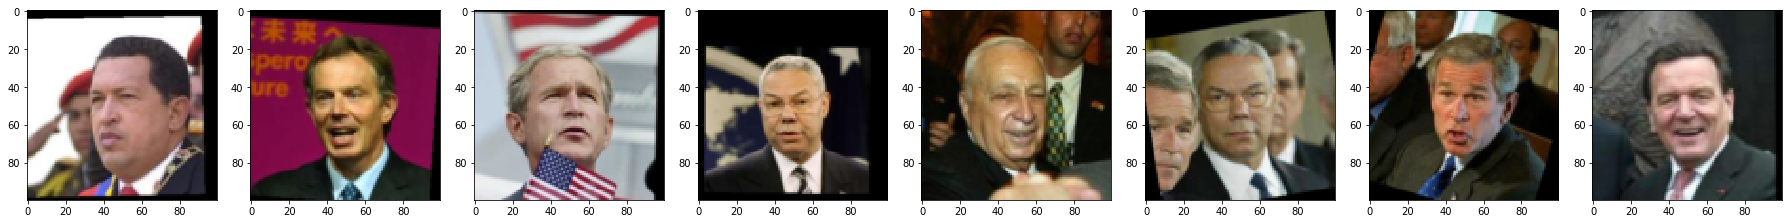

In [32]:
plt.figure(figsize=(25,25))

for i in np.arange(8):
    plt.subplot(1,8,i+1)
    plt.imshow(datalfw.images[i]/255)
    plt.tight_layout()

#### Select only two candidates

In [71]:
print(datalfw.target_names)
filterim=pd.DataFrame(datalfw.target).isin([3,6])[0]
datafiltered=pd.DataFrame(datalfw.data)[filterim]
yfiltered=datalfw.target[filterim]

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Tony Blair']


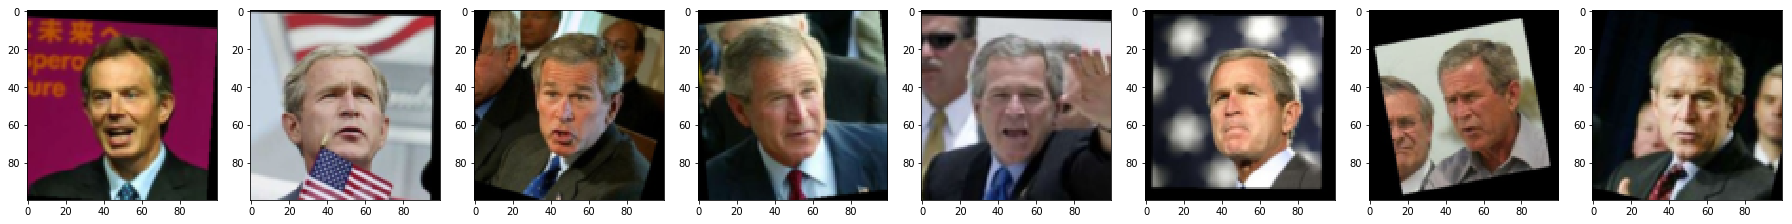

In [70]:
plt.figure(figsize=(25,25))

datafiltered_images=datalfw.images[filterim]
for i in np.arange(8):
    plt.subplot(1,8,i+1)
    plt.imshow(datafiltered_images[i]/255)
    plt.tight_layout()

In [74]:
yfiltered


### on split les données
X_train, X_test, y_train, y_test = train_test_split(datafiltered,yfiltered,test_size = 0.25, random_state = 0) # on split en train et test
# Show the results of the split
print("Training set has {} samples.".format(X_train.shape))
print("Testing set has {} samples.".format(X_test.shape))


### on applique grid search sur le paramètre C
parameters = {'C':[0.001,0.01, 0.1,1,10]}
svmmodel=SVC( kernel='linear',probability=False, tol=0.001, random_state=None)


clf = GridSearchCV(svmmodel, parameters, cv=5)
clf.fit(X_train, y_train)

print ( "The score of the model after cross-validation is %.2f" %clf.score(X_test,y_test))


Training set has (505, 30000) samples.
Testing set has (169, 30000) samples.
The score of the model after cross-validation is 0.96


In [75]:
clf.grid_scores_

[mean: 0.94851, std: 0.00991, params: {'C': 0.001},
 mean: 0.94851, std: 0.00991, params: {'C': 0.01},
 mean: 0.94851, std: 0.00991, params: {'C': 0.1},
 mean: 0.94851, std: 0.00991, params: {'C': 1},
 mean: 0.94851, std: 0.00991, params: {'C': 10}]

On voit que l'erreur ne dépend pas de C 